<a href="https://colab.research.google.com/github/geoworldlook/F1_predict_model/blob/main/compare_results_after_race.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from sklearn.preprocessing import StandardScaler

def process_race_data(model_path, data_path, real_data_path, scaler_path, driver, seq_length=5, threshold=1):
    """
    Funkcja przetwarzająca dane wyścigowe, przewidująca czasy okrążeń oraz obliczająca statystyki błędów.

    Parametry:
    - model_path: ścieżka do modelu Keras.
    - data_path: ścieżka do pliku z danymi treningowymi (CSV).
    - real_data_path: ścieżka do pliku z rzeczywistymi danymi wyścigowymi (CSV).
    - scaler_path: ścieżka do obiektu StandardScaler.
    - driver: identyfikator kierowcy.
    - seq_length: długość sekwencji dla danych (domyślnie 5).
    - threshold: próg wykrywania wartości odstających (domyślnie 1).

    Zwraca:
    - statystyki błędów oraz porównanie czasów rzeczywistych i przewidywanych.
    """

    # Wczytaj model
    model = tf.keras.models.load_model(model_path)

    # Wczytaj dane treningowe
    new_train_data = pd.read_csv(data_path)

    # Wczytaj dane rzeczywiste
    real_data = pd.read_csv(real_data_path)
    real_data['LapTime_seconds'] = real_data['LapTime_seconds'].fillna(0)

    # Przewidywanie czasów
    predicted_times = predict_full_race_times(new_train_data, seq_length, real_data)

    # Zapisz przewidywane czasy
    predicted_times_df = pd.DataFrame(predicted_times, columns=['LapTime_seconds'])
    predicted_times_df.to_csv(f"predicted_times_{driver}.csv", index=False)

    # Filtrowanie wartości odstających
    filtered_predicted_times = remove_outliers(predicted_times, threshold)

    # Aplikacja filtra Kalmana
    filtered_times_kalman = kalman_filter(filtered_predicted_times)
    filtered_times_kalman = remove_outliers(filtered_times_kalman, threshold)

    # Załaduj obiekt StandardScaler
    scaler = joblib.load(scaler_path)

    # Przywracanie oryginalnych wartości z przeskalowanych danych
    original_predicted_times_kalman = inverse_scale_data(scaler, filtered_times_kalman, 'LapTime_seconds')
    original_predicted_times = inverse_scale_data(scaler, predicted_times, 'LapTime_seconds')

    # Obliczanie statystyk błędu
    stats = calculate_error_stats(real_data['LapTime_seconds'].values, original_predicted_times)

    # Wizualizacja porównawcza
    plt.figure(figsize=(12, 6))
    plt.plot(real_data['LapTime_seconds'].values, label=f'Real Times - {driver}', color='blue')
    plt.plot(original_predicted_times_kalman, linestyle='-', label=f'Kalman Filter - {driver}', color='red')
    plt.plot(original_predicted_times, linestyle='--', label=f'Predicted Times - {driver}', color='orange')
    plt.xlabel('Lap')
    plt.ylabel('Lap Time (seconds)')
    plt.title(f'Comparison of Predicted, Real Lap Times and Kalman Filter for {driver}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return stats


def inverse_scale_data(scaler, data, column_name):
    """
    Odwrotne skalowanie danych z wykorzystaniem MinMaxScaler.

    Parametry:
    - scaler: obiekt StandardScaler.
    - data: dane do odwrotnego przeskalowania.
    - column_name: nazwa kolumny w danych, do której odnosi się skalowanie.

    Zwraca:
    - Oryginalne wartości przeskalowane.
    """
    column_index = list(scaler.feature_names_in_).index(column_name)
    min_val = scaler.data_min_[column_index]
    max_val = scaler.data_max_[column_index]
    original_data = data * (max_val - min_val) + min_val
    return original_data


def remove_outliers(data, threshold=2):
    """
    Funkcja do wykrywania i filtrowania wartości odstających.

    Parametry:
    - data: dane wejściowe.
    - threshold: próg wykrywania wartości odstających.

    Zwraca:
    - Przefiltrowane dane bez wartości odstających.
    """
    mean = np.mean(data)
    std_dev = np.std(data)
    outliers = np.abs(data - mean) > threshold * std_dev
    filtered_data = data.copy()

    for i in range(len(data)):
        if outliers[i]:
            if i == 0 and len(data) >= 5:
                filtered_data[i] = np.mean(data[:5])
            elif i == len(data) - 1:
                filtered_data[i] = np.mean(data[-5:])
            else:
                filtered_data[i] = (data[i-1] + data[i+1]) / 2
    return filtered_data


def kalman_filter(predictions, Q=1e-5, R=0.1**2):
    """
    Funkcja implementująca filtr Kalmana.

    Parametry:
    - predictions: dane wejściowe.
    - Q: wariancja procesu (domyślnie 1e-5).
    - R: wariancja szumu pomiarowego (domyślnie 0.01).

    Zwraca:
    - Wygładzone dane po zastosowaniu filtra Kalmana.
    """
    n = len(predictions)
    xhat = np.zeros(n)
    P = np.zeros(n)
    xhat[0] = predictions[0]
    P[0] = 1.0

    for k in range(1, n):
        xhatminus = xhat[k-1]
        Pminus = P[k-1] + Q
        K = Pminus / (Pminus + R)
        xhat[k] = xhatminus + K * (predictions[k] - xhatminus)
        P[k] = (1 - K) * Pminus

    return xhat


def calculate_error_stats(real_times, predicted_times):
    """
    Funkcja do obliczenia szczegółowych statystyk błędów.

    Parametry:
    - real_times: rzeczywiste czasy okrążeń.
    - predicted_times: przewidywane czasy okrążeń.

    Zwraca:
    - Statystyki błędów (MAE, MSE, RMSE, MAPE, R2).
    """
    mae = mean_absolute_error(real_times, predicted_times)
    mse = mean_squared_error(real_times, predicted_times)
    rmse = mse ** 0.5
    mape = np.mean(np.abs((real_times - predicted_times) / real_times)) * 100
    r2 = r2_score(real_times, predicted_times)

    # Dodatkowe statystyki
    med_error = np.median(np.abs(real_times - predicted_times))  # Mediana błędu
    max_error = np.max(np.abs(real_times - predicted_times))      # Maksymalny błąd
    perc_95 = np.percentile(np.abs(real_times - predicted_times), 95)  # 95 percentyl błędów

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared (R2): {r2:.2f}")
    print(f"Median Absolute Error: {med_error:.2f}")
    print(f"Max Error: {max_error:.2f}")
    print(f"95th Percentile Error: {perc_95:.2f}")

    return mae, mse, rmse, mape, r2, med_error, max_error, perc_95


def predict_full_race_times(new_train_data, seq_length, comparison_data):
    """
    Funkcja do przewidywania czasów wyścigu na podstawie danych treningowych.

    Parametry:
    - new_train_data: dane treningowe.
    - seq_length: długość sekwencji danych.
    - comparison_data: dane porównawcze.

    Zwraca:
    - Przewidywane czasy wyścigu.
    """
    X_new_train_data = new_train_data.drop(['driver_id'], axis=1)
    X_new_train_seq = create_sequences(X_new_train_data, seq_length)
    predicted_race_times = model.predict(X_new_train_seq)

    last_sequence = X_new_train_seq[-1]
    missing_laps = len(comparison_data) - len(predicted_race_times)

    for _ in range(missing_laps):
        next_lap_time = model.predict(last_sequence[np.newaxis, :, :])[0]
        next_lap_time_expanded = np.full((last_sequence.shape[1],), next_lap_time)
        last_sequence = np.vstack([last_sequence[1:], next_lap_time_expanded])
        predicted_race_times = np.append(predicted_race_times, next_lap_time)

    return predicted_race_times


def create_sequences(data, seq_length):
    """
    Funkcja do tworzenia sekwencji z danych.

    Parametry:
    - data: dane wejściowe.
    - seq_length: długość sekwencji.

    Zwraca:
    - Tablica sekwencji.
    """
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-14-06829a27624c>:163: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((real_times - predicted_times) / real_times)) * 100


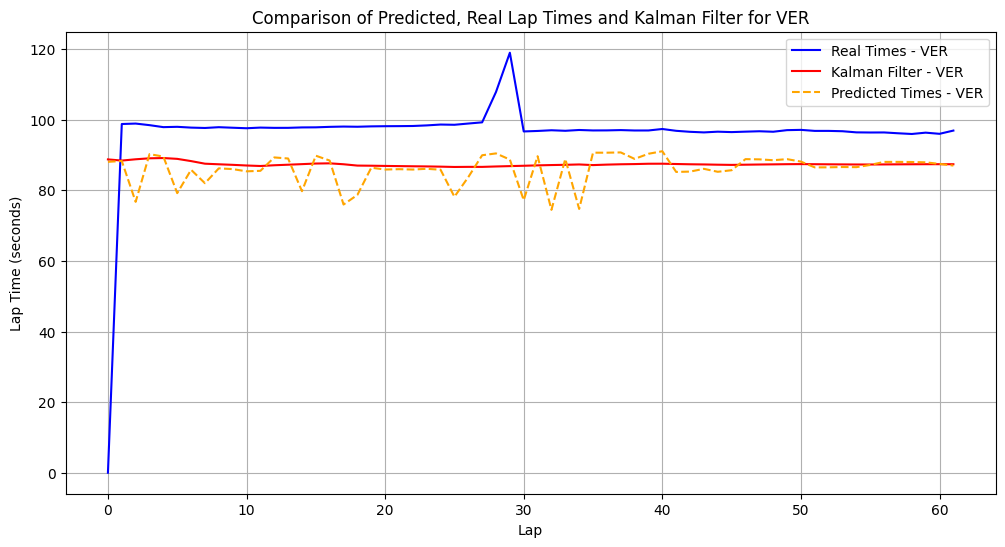

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mean Absolute Error (MAE): 12.82
Mean Squared Error (MSE): 295.71
Root Mean Squared Error (RMSE): 17.20
Mean Absolute Percenta

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-14-06829a27624c>:163: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((real_times - predicted_times) / real_times)) * 100


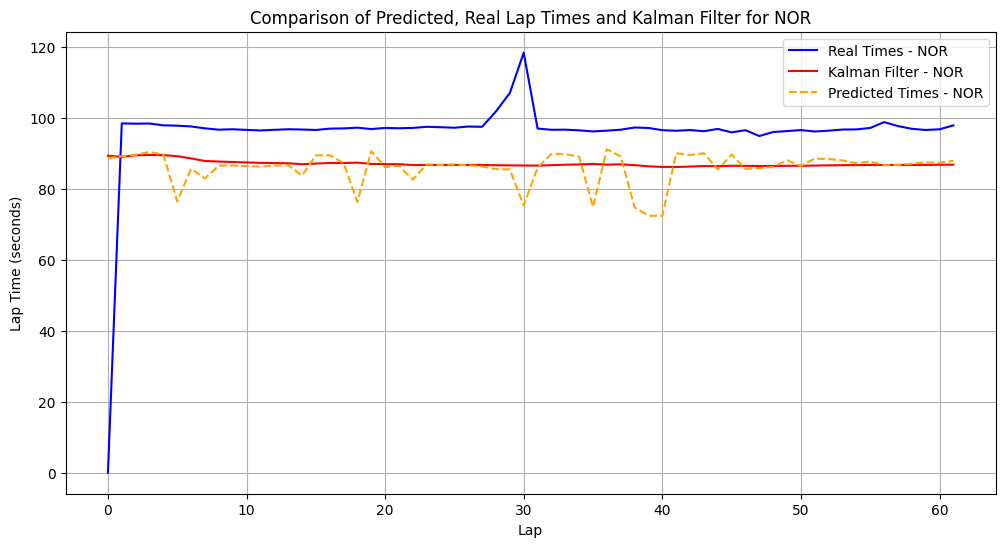

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-14-06829a27624c>:163: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((real_times - predicted_times) / real_times)) * 100


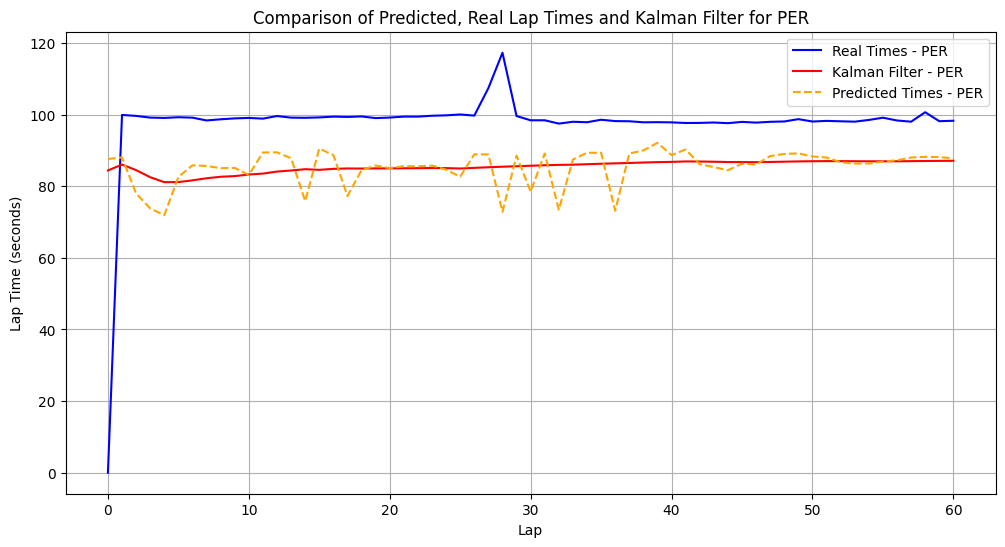

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Mean Absolute Error (MAE): 13.50
Mean Squared Error (MSE): 313.95
Root Mean Squared Error (RMSE): 17.72
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): -0.93
Median Absolute Error: 10.39
Max

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-14-06829a27624c>:163: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((real_times - predicted_times) / real_times)) * 100


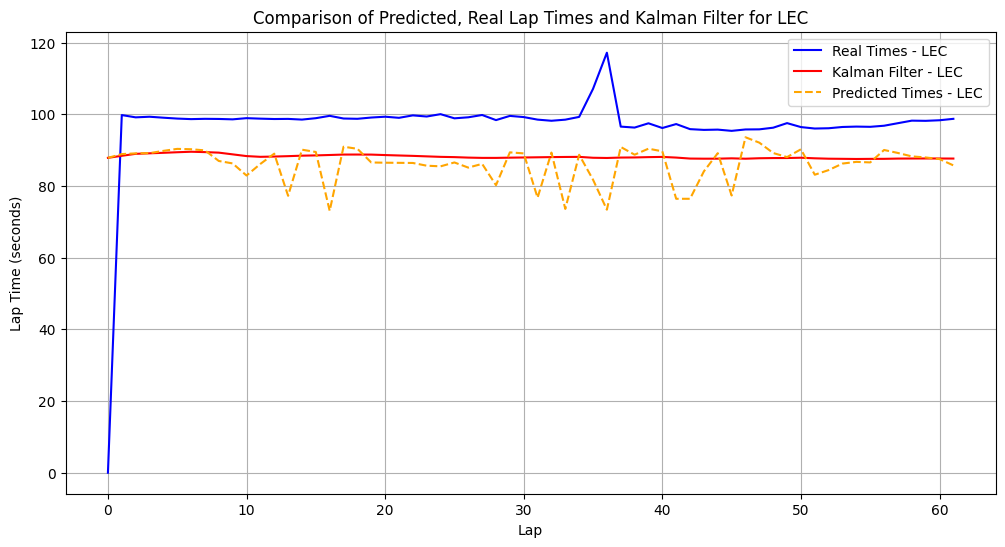

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Mean Absolute Error (MAE): 13.73
Mean Squared Erro

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-14-06829a27624c>:163: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((real_times - predicted_times) / real_times)) * 100


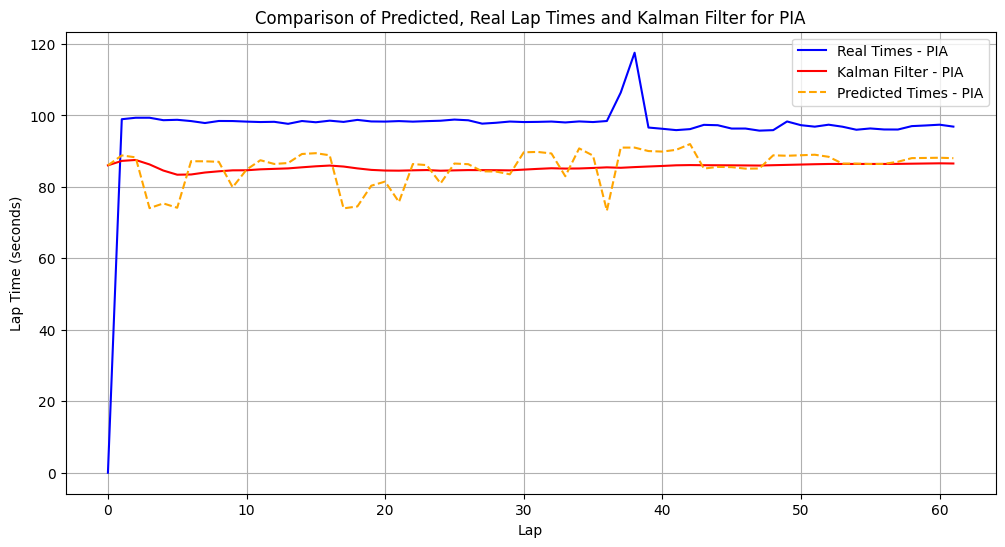

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-14-06829a27624c>:163: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((real_times - predicted_times) / real_times)) * 100


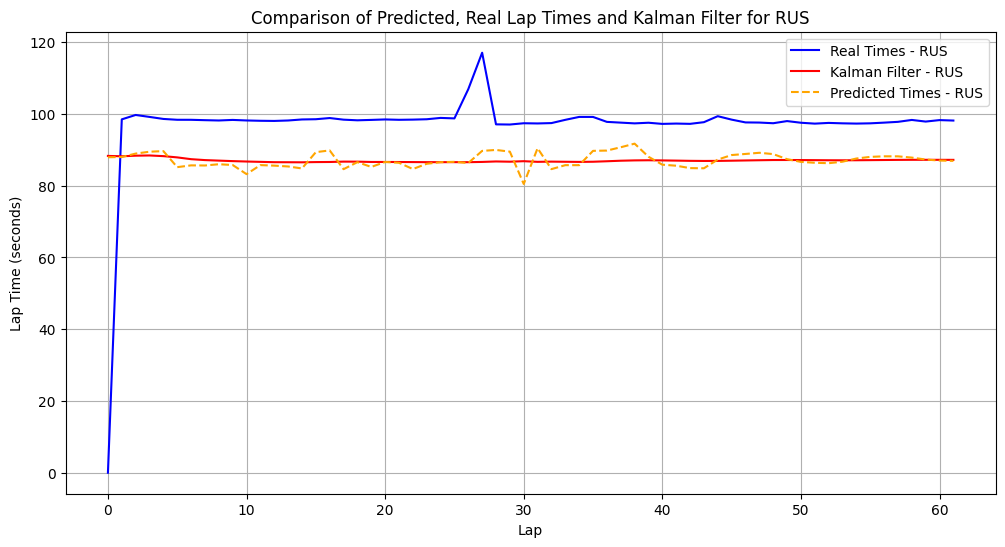

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Mean Absolut

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-14-06829a27624c>:163: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((real_times - predicted_times) / real_times)) * 100


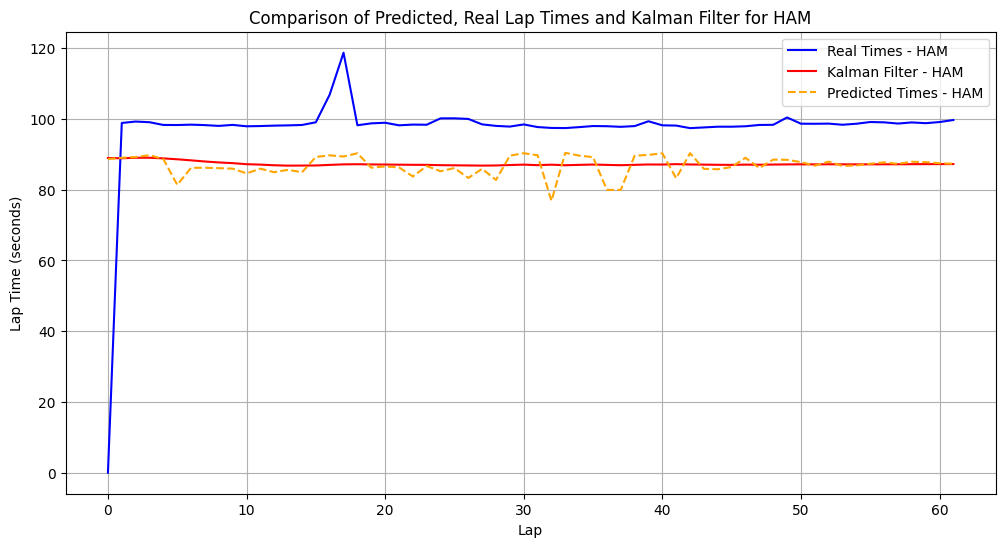

In [ ]:
for driver in driver_list:
  # Ścieżki do plików
  model_path = f"/content/drive/MyDrive/F1_MODEL/with_points/2022_2024/model_v3/model_trained_with_best_hyperparams_and_race_data_{driver}_{type_objective}_points_huber_mini_max_scaler.h5"
  data_path = f"/content/drive/MyDrive/F1_MODEL/with_points/2022_2024/mini_max_scaler/singapur_2024_fp1_fp2_fp3_q_points_fp1_fp2_fp3_q_points_mini_max_scaler_{driver}.csv"
  real_data_path = f"/content/drive/MyDrive/F1_MODEL/with_points/check_after_race/lap_times_{driver}.csv"
  scaler_path = '/content/drive/MyDrive/F1_MODEL/with_points/2022_2024/mini_max_scaler/scaler_points_MinMaxScaler.pkl'


  # Wywołanie funkcji
  stats = process_race_data(
      model_path=model_path,
      data_path=data_path,
      real_data_path=real_data_path,
      scaler_path=scaler_path,
      driver=driver,
      seq_length=5,  # Domyślna długość sekwencji
      threshold=1    # Domyślny próg wartości odstających
  )

